In [1]:
# import general packages, check folders
#%reset
import os
import numpy as np
import h5py
import pandas as pd
#import imagesc as imagesc #pip install imagesc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
from pathlib import Path

# TO DO - REMOVE THE UNNECESSARY LIBRARY IMPORTS

%matplotlib inline

working_dir = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code'
#working_dir = os.getcwd()
print('current directory:\n',working_dir)
path = Path(working_dir)
parent_folder = path.parent
#print('parent folder:', parent_folder)
data_file_loc = os.path.join(parent_folder,'data') # to store data we extract later in this notebook

current directory:
 /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code


In [2]:
# setting default fontsizes for plots

s=16 # CHANGE FONTSIZE HERE
plt.rc('font', size=s) #controls default text size
plt.rc('axes', titlesize=s) #fontsize of the title
plt.rc('axes', labelsize=s) #fontsize of the x and y labels
plt.rc('xtick', labelsize=s) #fontsize of the x tick labels
plt.rc('ytick', labelsize=s) #fontsize of the y tick labels
plt.rc('legend', fontsize=s) #fontsize of the legend
#import matplotlib as mpl
#mpl.rcParams['font.weight']= 'normal'

In [3]:
#suff= ' '
suff = '_corrected'

In [4]:
# load behavioral data - coded 1 for "social", 0 for "nonsocial" and 9 for "unsure", nan for missed response
# even if using the Mental/Random labels, need this to sub-select subs who have responded on all trials
responses = np.load(os.path.join(data_file_loc,f'responses{suff}.npy'))
responses.shape # subs *movies

(1049, 10)

In [5]:
vid_joined = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical","Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]
vid_joined

['COAXING-B',
 'BILLIARD-A',
 'DRIFTING-A',
 'Fishing',
 'Random mechanical',
 'Scaring',
 'SEDUCING-B',
 'STAR-A',
 'SURPRISING-B',
 'TENNIS-A']

In [6]:
print('Nr of complete subs:',len(np.where(np.array([len(np.where(~np.isnan(responses[s,:]))[0]) for s in range(responses.shape[0])])==10)[0]))
print('total subs:', responses.shape[0])

Nr of complete subs: 814
total subs: 1049


In [42]:
[timepts_indiv_movie,vid_start_rel_tr] = np.load(os.path.join(data_file_loc,'Video_TRs.npy'),allow_pickle=True)
vid_start_rel_tr

array([6, 13, 13, 13, 13, 6, 13, 13, 13, 13], dtype=object)

# LME stim label vs. response label

In [43]:
vidnames = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical","Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]

# creating a 3D array of beta coeffs across movies from individual movie files
all_coefs = np.zeros((responses.shape[0],268,10))

for m in range(10):
    fileName =  os.path.join(data_file_loc,'coefs_run_norm','slope_reg',f'coef_slopereg_runnorm_{vidnames[m]}{suff}.npy')
    all_coefs[:,:,m] = np.load(fileName)
    #print(dat.shape)

all_coefs[:10,0,:2]

array([[ 9.33693863e-01,  1.66709840e-01],
       [ 2.46438372e+00,  6.79413212e-01],
       [-4.82038901e-01, -6.60210885e-01],
       [ 9.71036189e-01,  1.97436306e+00],
       [-8.99258171e-01, -2.68430814e-01],
       [ 6.55118512e-01, -1.78271651e-03],
       [ 1.27985989e+00, -7.11127922e-01],
       [ 5.54624492e-01,  1.54513876e-01],
       [ 9.87224895e-01,  2.01677021e+00],
       [ 6.72424811e-02,  4.51586746e-01]])

In [44]:
# first of all, best to remove subjects with < 10 responses for power in general
count_resp = np.zeros((responses.shape[0],))
for i in range(responses.shape[0]):
    count_resp[i] = len(np.where(~np.isnan(responses[i,:]))[0])
subs_10resp = np.where(count_resp == 10)[0]
len(subs_10resp)

814

In [45]:
#install lme functions
from pymer4.models import Lmer
#from pymer4.models import Lm
import time
from datetime import datetime
stimType = [1,0,0,1,0,1,1,0,1,0]

In [46]:
coef_ALL_stim, coef_ALL_resp = [np.empty((268,)) for _ in range(2)]
coef_ALL_stim[:], coef_ALL_resp[:] = [np.nan]*2

pval_ALL_stim, pval_ALL_resp = [np.empty((268,)) for _ in range(2)]
pval_ALL_stim[:], pval_ALL_resp[:] = [np.nan]*2

AIC_ALL_stim, AIC_ALL_resp = [np.empty((268,)) for _ in range(2)]
AIC_ALL_stim[:], AIC_ALL_resp[:] = [np.nan]*2


In [79]:
# STMTYPE BASED
load_all = 1 # 1: load saved coefs, 0: run the LME
if load_all == 1:
     df_all_coefs = pd.read_csv(os.path.join(data_file_loc,'coefs_run_norm','slope_reg','LME_S_NS_revision1','lmecoefs_all_S_NS_stimType.csv'))
     #[coef_ALL_stim,pval_ALL_stim] = np.load(os.path.join(data_file_loc,'coefs_run_norm','slope_reg','LME_S_NS_revision1','lmecoefs_all_S_NS_stimType.npy'), allow_pickle=True)
else:
    start_time =  time.time()
    for n in range(268):
        if n%10 == 0:
            print(f'node {n+1},time={(time.time()-start_time)/60:.2f} mins')
        
        df = pd.DataFrame(columns = ['coefs','stimType','subID','movie'])
        for m in range(10):
            df_temp = pd.DataFrame({'coefs': all_coefs[subs_10resp,n,m],'stimType':stimType[m], 'response':responses[subs_10resp,m],'subID':subs_10resp,\
                 'movie':np.repeat(m,len(subs_10resp))})
            df = df.append(df_temp,ignore_index=True)
            df = df.loc[df['response'] != 9] # yes v no
        
        df['stimType'] = df['stimType'].map({1.0: "Mental", 0.0:  "Random"})
        df['response'] = df['response'].map({1.0: "Non-social", 0.0:  "Social"})
        
        model1 = Lmer('coefs ~  stimType +(1|subID) + (1|movie)', data=df) # ff: mean response, rf:subjID
        model1.fit(factors={"stimType":["Random","Mental"]},summary = False, verbose = False)
        model2 = Lmer('coefs ~  response +(1|subID) + (1|movie)', data=df) # ff: mean response, rf:subjID
        model2.fit(factors={"response":["Non-social","Social"]},summary = False, verbose = False)

        if n == 0:
            print('model:',model1.fit(factors={"stimType":["Random","Mental"]}))
            print('model:',model2.fit(factors={"response":["Non-social","Social"]}))

        coef_ALL_stim[n] = model1.coefs['Estimate'][1]
        pval_ALL_stim[n]= model1.coefs['P-val'][1]
        AIC_ALL_stim[n]= model1.AIC

        coef_ALL_resp[n] = model2.coefs['Estimate'][1]
        pval_ALL_resp[n]= model2.coefs['P-val'][1]
        AIC_ALL_resp[n]= model2.AIC
        
    df_all_coefs = pd.DataFrame({'Node': np.arange(268), 'coef_stim': coef_ALL_stim, 'pval_stim': pval_ALL_stim, 'AIC_stim': AIC_ALL_stim,\
        'coef_resp': coef_ALL_resp, 'pval_resp': pval_ALL_resp, 'AIC_resp': AIC_ALL_resp})
    df_all_coefs.to_csv(os.path.join(data_file_loc,'coefs_run_norm','slope_reg','LME_S_NS_revision1','lmecoefs_all_S_NS_stimType.csv'))
    #np.save(os.path.join(data_file_loc,'coefs_run_norm','slope_reg','LME_S_NS_revision1','lmecoefs_all_S_NS_stimType.npy'), [coef_ALL_stim,pval_ALL_stim])
    print('Done on/at:',datetime.now()) # cell run at)

<AxesSubplot:>

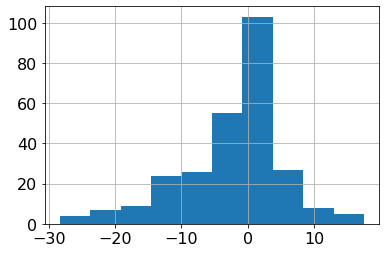

In [80]:
df_all_coefs['AIC resp-stim']= df_all_coefs['AIC_resp'] - df_all_coefs['AIC_stim']
df_all_coefs['AIC resp-stim'].hist()

# Plot AIC on brain

In [81]:
from nilearn.surface import vol_to_surf
from nilearn.plotting import plot_glass_brain, plot_surf_roi,plot_stat_map,plot_img,plot_surf_contours
import nibabel as nib
from nilearn import datasets
bg_img = datasets.load_mni152_template()
fig_save_loc = os.path.join('/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/paper_prep/figures/fig3_glm_soc_vs_nonsoc/ALL_MentalRandom')

from nilearn.datasets import fetch_surf_fsaverage
fsaverage = fetch_surf_fsaverage()

from nilearn import datasets
bg_img = datasets.load_mni152_template()

from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain

mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)


def color_rois(values):
    
    """
    This function assumes you are passing a vector "values" with the same length as the number of nodes in the atlas.
    """
    shen268 = nib.load(os.path.join(data_file_loc,"shen_2mm_268_parcellation.nii.gz"))
    shen268_data = shen268.get_fdata()
    img = np.zeros(shen268_data.shape)
    #print(shen268_data.shape)
    for roi in range(len(values)):
        itemindex = np.where(shen268_data==roi+1) # find voxels in this node (add 1 to account for zero-indexing)
        #print(len(itemindex[0]))
        img[itemindex] = values[roi] # color them by the desired value 

    affine = shen268.affine
    img_nii = nib.Nifti1Image(img, affine)
    
    return img_nii

In [82]:
data_file_loc

'/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/data'

In [83]:
nodes_coaxbill_rand_all = np.load(os.path.join(data_file_loc,'nodes_coaxbill_rand_all.npy')) # sig nodes hihglighted in the first S>NS GLM
# for contours

In [62]:
def surf_plot1(fig,ax,nodes,params, thresh):

    title_txt = params['title']
    txt  = params['txt']
    vmin = params['vmin']
    vmax = params['vmax']

    #LH
    ax_surf = ax[0,0]
    texture = vol_to_surf(color_rois(nodes), fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    surf_plot1=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_left,axes = ax_surf, threshold =  thresh)#)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})

    texture_contour = vol_to_surf(color_rois(nodes_coaxbill_rand_all), fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
    plot_surf_contours(fsaverage.infl_left, texture_contour, axes = ax_surf,figure=surf_plot1, legend=True,levels = [1], colors=['k'])

    ax_surf = ax[1,0]
    surf_plot2=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_left, view = 'medial',axes = ax_surf, threshold =  thresh)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    plot_surf_contours(fsaverage.infl_left, texture_contour, axes = ax_surf,figure=surf_plot2, legend=True,levels = [1], colors=['k'])


    #RH
    ax_surf = ax[0,1]
    texture = vol_to_surf(color_rois(nodes), fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    surf_plot3=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=True,symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_right,axes = ax_surf, threshold =  thresh)#)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    texture_contour = vol_to_surf(color_rois(nodes_coaxbill_rand_all), fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    plot_surf_contours(fsaverage.infl_right, texture_contour, axes = ax_surf,figure=surf_plot3, legend=True,levels = [1], colors=['k'])

    surf_plot3.axes[4].text(10,.5*vmax,s=txt,fontsize=20, fontdict = {'verticalalignment':'top','horizontalalignment':'left','rotation':0})
    box = surf_plot3.axes[4].get_position()
    surf_plot3.axes[4].set_position([box.x0*.93, box.y0-.5, box.width, box.height*2])  # move a bit the bar to the right, need to divide by number of columns (to move relative to last figure only, not to overall row, else will get too far away)
    

    ax_surf = ax[1,1]
    surf_plot4=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=False,symmetric_cmap=True, vmin = vmin, vmax = vmax,
                                bg_map=fsaverage.sulc_right, view ='medial',axes = ax_surf, threshold =  thresh)#)#,vol_to_surf_kwargs={"n_samples": 10, "radius": 10, "interpolation": "nearest","kind":'ball'})
    plot_surf_contours(fsaverage.infl_right, texture_contour, axes = ax_surf,figure=surf_plot4, legend=True, levels = [1], colors=['k'])#, labels=['Sig. (q<.05) across\n(a),(c),(d)'])
    
    #v5_texture = vol_to_surf(v5_roi_nii,                          fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
    #thr99 = np.quantile(v5_texture,.99)
    #v5_texture[v5_texture<thr99] = 0
    #v5_texture[v5_texture!=0] = 1
    #plot_surf_contours(fsaverage.infl_right, v5_texture, figure=surf_plot3, legend=False, axes=ax[0,1],levels=[1],colors=['g'])#,levels = [texture],  labels=['Fig 3 nodes'])
    #plot_surf_contours(fsaverage.infl_right, v5_texture, figure=surf_plot4, legend=False, axes=ax[0,1],levels=[1],colors=['g'])#,levels = [texture],  labels=['Fig 3 nodes'])


    ax[0,0].dist = 7 # change viewing distance to "zoom in" to surface plots
    ax[0,1].dist = 7
    ax[1,0].dist = 7
    ax[1,1].dist = 7

    #fig.colorbar(surf_plot3.axes[2])
    plt.subplots_adjust(left=0,
                        bottom=0, 
                        right=.8, 
                        top=1, 
                        wspace=0.0, 
                        hspace=-.1)
    #fig.colorbar(surf_plot2, shrink=2, aspect=10)
#box = surf_plot3.axes[4].get_position()
#surf_plot3.axes[4].set_position([box.x0, box.y0, box.width, box.height])  # move a bit the bar to the right, need to divide by number of columns (to move relative to last figure only, not to overall row, else will get too far away)
    

In [63]:
'''fig_save_loc = os.path.join('/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/paper_prep/figures/fig3_glm_soc_vs_nonsoc/ALL_MentalRandom')
from importlib import reload
reload(brain_plot_functions)'''
#v5_roi = 'v5_association-test_z_FDR_0.01.nii'
#v5_roi_loc = f'/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/data/ROIs/{v5_roi}'
#v5_roi_nii = nib.load(v5_roi_loc)
min(df_all_coefs['AIC resp-stim']),max(df_all_coefs['AIC resp-stim'])

(-28.326528419351234, 17.53925560431162)

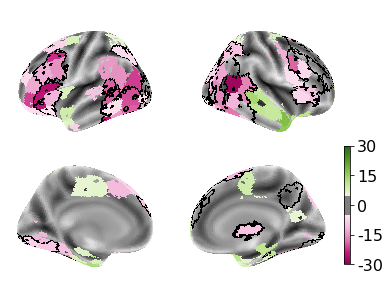

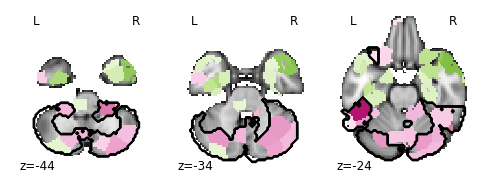

In [115]:
# surface plots
vmin,vmax = -30,30
cmap = 'PiYG' #'RdBu_r'
#txt = r' $\overline{\beta}(\""")-$' + '\n' + r'$\overline{\beta}_{Non-social}$'+ '\n'
title_txt = 'AIC RESP V. STIM'
 
nodes = np.zeros((268,))
txt = ''#'AIC response-\nbased LME - \nstim-based LME' #'AIC S/NS LME - M/R LME'#r"$\overline{\beta}{(diff)}$"
nodes = df_all_coefs['AIC resp-stim']
thresh = 5

fig,ax = plt.subplots(nrows=2, ncols= 2,figsize=(6,4),subplot_kw={'projection': '3d'})
params = {'title':title_txt,'txt':txt, 'vmin': vmin, 'vmax':vmax}
surf_plot1(fig,ax,nodes,params, thresh)
plt.savefig(os.path.join(fig_save_loc,f'AIC_surf_thresh{thresh}.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
    
img = roi_to_brain(pd.Series(nodes), mask_x)
coords = [-44,-34,-24] # initial exploration
ax_plot = plot_img(img.to_nifti(), display_mode = 'z',vmin = vmin, vmax = vmax, cut_coords =coords,cmap = cmap, bg_img = bg_img,colorbar= False,threshold = thresh)
ax_plot.add_contours(color_rois(nodes_coaxbill_rand_all),linewidths=1, colors=['k'],linestyles ='-',filled=False)

plt.savefig(os.path.join(fig_save_loc,f'AIC_axial_thresh{thresh}.png'),dpi=300,bbox_inches='tight',facecolor='white', edgecolor='none')
#plt.clf()

In [84]:
df_all_coefs['AIC resp-stim'].values

array([ 3.40020183e+00,  4.72754722e+00,  3.21637952e+00,  1.97842115e-01,
        2.22760003e+00,  8.21262312e+00,  4.98884845e-01,  7.87753205e-01,
       -1.92030714e+00, -1.70187374e-01,  5.08226188e-01, -4.66292402e+00,
       -5.14528343e-01, -4.87260904e+00,  2.37373461e+00, -1.06163900e+01,
        7.09045023e-01,  1.11887048e+01, -4.72048191e+00, -7.47193854e+00,
       -6.30586283e+00, -7.11751470e+00,  2.13111372e+00,  4.64312055e+00,
        8.72579173e+00,  7.31802932e+00, -1.24245880e+01, -4.42219292e+00,
       -1.15661866e+01, -6.00441296e-01, -1.91895722e+01,  4.64640881e+00,
        1.00953445e+00,  5.67317799e-01,  3.50028811e+00, -4.59760728e+00,
        1.65858593e-01,  2.83810351e+00,  1.09777524e+00,  8.39430979e-01,
        5.18627684e+00,  6.21828197e-01, -1.01504597e+01, -1.06418742e+00,
        1.68736530e+00,  1.64956848e+00, -4.61441372e+00, -5.26236708e-01,
       -1.32758395e+01, -2.83265284e+01,  5.38522333e+00,  1.54771602e+01,
        1.75392556e+01,  

In [103]:
diff2_nodes = np.where(np.abs(df_all_coefs['AIC resp-stim'].values) > 2)[0]
diff2_nodes, len(diff2_nodes)

(array([  0,   1,   2,   4,   5,  11,  13,  14,  15,  17,  18,  19,  20,
         21,  22,  23,  24,  25,  26,  27,  28,  30,  31,  34,  35,  37,
         40,  42,  46,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
         58,  59,  62,  63,  64,  65,  66,  67,  68,  70,  72,  73,  74,
         75,  77,  80,  82,  83,  85,  87,  88,  89,  90,  91,  93,  94,
         95,  96,  98,  99, 101, 102, 103, 105, 106, 107, 110, 111, 112,
        113, 115, 118, 120, 123, 127, 132, 134, 136, 137, 138, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 158, 159, 160, 163, 165, 166, 167, 170, 174, 176, 179, 181,
        182, 183, 185, 186, 187, 190, 191, 193, 194, 196, 197, 198, 199,
        200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 212, 213,
        214, 216, 217, 220, 221, 227, 230, 231, 232, 233, 234, 235, 236,
        238, 239, 240, 241, 246, 247, 252, 254, 255, 257, 260, 261, 262,
        264, 266]),
 171)

In [104]:
diff5_nodes = np.where(np.abs(df_all_coefs['AIC resp-stim'].values) > 5)[0]
diff5_nodes, len(diff5_nodes)

(array([  5,  15,  17,  19,  20,  21,  24,  25,  26,  28,  30,  40,  42,
         48,  49,  50,  51,  52,  53,  56,  59,  62,  63,  64,  65,  66,
         68,  70,  72,  73,  74,  80,  85,  91,  94,  95,  96,  99, 101,
        102, 103, 105, 111, 112, 113, 115, 120, 127, 134, 138, 142, 143,
        144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 160,
        163, 165, 167, 174, 176, 182, 183, 185, 186, 187, 190, 191, 193,
        194, 197, 198, 199, 200, 201, 202, 205, 206, 208, 209, 210, 212,
        216, 217, 231, 233, 234, 235, 239, 241, 247, 252, 255, 257, 260,
        266]),
 105)

In [105]:
nodes_common = np.where(nodes_coaxbill_rand_all)[0]
nodes_common, len(nodes_common)

(array([  8,   9,  11,  12,  13,  15,  18,  19,  21,  28,  29,  30,  42,
         47,  48,  49,  64,  65,  66,  68,  69,  70,  72,  73,  75,  80,
         89,  99, 101, 103, 104, 106, 107, 110, 111, 112, 113, 115, 116,
        118, 127, 144, 146, 148, 150, 152, 154, 155, 156, 176, 191, 198,
        199, 200, 203, 205, 206, 208, 209, 212, 213, 235, 239, 240, 241,
        245, 246, 251, 252, 255]),
 70)

In [113]:
test_AIC_diff = -2
np.exp(test_AIC_diff/2)

0.36787944117144233

In [107]:
len(set(nodes_common) & set(diff2_nodes))

60

In [102]:
set(nodes_common) & set(diff5_nodes), len(set(nodes_common) & set(diff5_nodes))

({15,
  19,
  21,
  28,
  30,
  42,
  48,
  49,
  64,
  65,
  66,
  68,
  70,
  72,
  73,
  80,
  99,
  101,
  103,
  111,
  112,
  113,
  115,
  127,
  144,
  146,
  148,
  150,
  152,
  154,
  155,
  156,
  176,
  191,
  198,
  199,
  200,
  205,
  206,
  208,
  209,
  212,
  235,
  239,
  241,
  252,
  255},
 47)